## Single Stage Detector
In this example, we use a Single-Shot Detector (SSD) model to perform object detection. 

In [1]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import swat
from swat import CASTable

### Connect to CAS

Create a connection object, s, using the SAS SWAT Python module

In [2]:
s = swat.CAS("<CASHOST>", <CASPORT>,"<CASUSER>")

### Read, check, and describe ONNX file
File from https://github.com/onnx/models/tree/master/vision/object_detection_segmentation/ssd 

In [3]:
# model path
onnxfile = "ssd-10.onnx"

# Read onnx
s.loadactionset('aStore')
with open(onnxfile,'rb') as file:
    blob = file.read()
blob_ = swat.blob(blob)

# Check if ONNX is valid
s.aStore.check(onnx=blob_)

# Describe ONNX model (before converting to ASTORE)
res = s.aStore.describe(onnx=blob_)
print(res)

NOTE: Added action set 'aStore'.
NOTE: It is a valid ONNX model
[AStore.Tab.Description]

 Basic Information
 
               Attribute    Value
 0            IR Version        4
 1         Model Version        0
 2                Domain         
 3            Doc String         
 4         Producer Name  pytorch
 5      Producer Version      1.1
 6   Operator Set Domain         
 7  Operator Set Version       10

[AStore.Tab.InputValueInfo]

 Input Information
 
     Name      Length ValueType               Shape ElementType
 0  image  17280000.0    Tensor  (1, 3, 1200, 1200)       FLOAT

[AStore.Tab.OutputValueInfo]

 Output Information
 
      Name  Length ValueType      Shape ElementType
 0  bboxes     NaN    Tensor  (1, ., 4)       FLOAT
 1  labels     NaN    Tensor     (1, .)       INT64
 2  scores     NaN    Tensor     (1, .)       FLOAT

+ Elapsed: 0.311s, user: 0.0819s, sys: 0.0699s, mem: 0.846mb


The `Input value Info` table above shows us that the model is expecting a shape of (1, 3, 1200, 1200), so we load images and then reshape them with the `processImages` action

### Load images

In [4]:
s.loadactionset('image')

s.table.addcaslib(activeonadd=False,
                  datasource={'srctype':'path'},
                  name='data',
                  path='/path/to/data',
                  subdirectories=True)
s.image.loadimages(
    path='images',
    caslib='data',
    decode=True,
    addColumns=["CHANNELCOUNT", "CHANNELTYPE", "HEIGHT", "WIDTH"],
    casout=dict(name='imagesOrig',replace=True),
)

NOTE: Added action set 'image'.
NOTE: Cloud Analytic Services added the caslib 'data'.
NOTE: Loaded 10 images from /path/to/data/images into Cloud Analytic Services table imagesOrig.


,casLib,Name,Rows,Columns,casTable
0,CASUSER(sasuser),imagesOrig,10,12,"CASTable('imagesOrig', caslib='CASUSER(sasuser)')"


### Resize images

In [5]:
# no padding or letterbox resizing, just resize to 224x224
encodedImage = True
inputColorOrder = 'RGB'

s.image.processimages(
    table='imagesOrig',
    imagefunctions=[
         dict(functionoptions=dict(functiontype='resize', w=1200, h=1200))
         ,
         {'options': {'functiontype': 'CONVERT_COLOR', 'type': 'BGR2RGB'}}
       ],
    decode=not encodedImage,
    copyvars=['_height_','_width_'],
    casout=dict(name='imagesResized',replace=True)
)

NOTE: The table IMAGESORIG contains decoded images.
NOTE: 10 of 10 images were processed successfully and saved as encoded images to the Cloud Analytic Services table imagesResized.


,casLib,Name,Rows,Columns,casTable
0,CASUSER(sasuser),imagesResized,10,7,"CASTable('imagesResized', caslib='CASUSER(mace..."


In [6]:
s.CASTable("imagesResized").head()

,_image_,_size_,_height_,_width_,_id_,_path_,_type_
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,399395,925,993,1,/path/to/data/images/image7.jpg,jpg
1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,348552,1632,1216,2,/path/to/data/images/image0.jpg,jpg
2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,425961,1632,1216,3,/path/to/data/images/image10.jpg,jpg
3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,710354,1224,1632,4,/path/to/data/images/image15.jpg,jpg
4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,524956,1296,960,5,/path/to/data/images/image16.jpg,jpg


### Define the classes
This ONNX model used the COCO dataset in training, consisting of 80 different classes

In [7]:
classList = [
"person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat", "traffic light",
"fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow",
"elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee",
"skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle",
"wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange",
"broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed",
"diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven",
"toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
]

## Save to ASTORE

#### Set normalization mean and standard arrays
These values are generally noted with the specific model

In [8]:
normstd_vals = [0.229, 0.224, 0.225]
normmean_vals = [0.485, 0.456, 0.406]

#### Flatten outputs
We know the dimensions of the output from describing the ONNX earlier and we can create labels to flatten the output so it is easier to deal with later.

The specific boxes and bounding box coordinates are completely dependent on the model.

In [9]:
boxldx = [str(i) for i in range(200)] # 200 boxes predicted for each image
coord = ["x1","y1","x2","y2"] # bounding box coordinates
boxCoord = boxldx + coord

#### Now save the ONNX to ASTORE

In [10]:
s.aStore.saveas(
           table="imagesResized",
           rstore=dict(name="ssdStore", replace=True),
           onnx=blob_,
           inputs=[dict(vars=["_image_"],shape=[1,3,1200,1200],varbinaryType="UINT8", 
                        inputShapeOrder='NHWC', inputColorOrder='BGR',
                        modelShapeOrder='NCHW', modelColorOrder='RGB',
                        preprocess='NORMALIZE', normFactor=255,
                        normmean=normmean_vals,
                        normstd=normstd_vals)],
            outputs=[dict(name="bboxes", shape=[1,200,4],labels=boxCoord, labelDim=[1,2]),
                     dict(name="labels", shape=[1,200], labels=boxldx, labelDim=[1]),
                     dict(name="scores", shape=[1,200], labels=boxldx, labelDim=[1])],
           )

NOTE: 80663755 bytes were written to the table "ssdStore" in the caslib "CASUSER(sasuser)".


+ Elapsed: 1.26s, user: 0.69s, sys: 0.334s, mem: 158mb

### Describe newly generated ASTORE
If we describe the output store, we can see that the output names from scoring will be based on the output names we specified in the saveas action. 

In [11]:
s.aStore.describe(rstore="ssdStore")

[Key]

 Store Key
 
                                         Key
 0  F2DC94DABA86FCF5B5EC4942B4091F35C0F0520C

[Description]

 Basic Information
 
          Attribute               Value
 0  Analytic Engine                onnx
 1     Time Created  23Nov2021:17:17:21

[InputVariables]

 Input Variables
 
       Name    Length Role Type    RawType FormatName
 0  _image_  856587.0   Id       Character           

[OutputVariables]

 Output Variables
 
               Name  Length Type                   Label
 0     P_bboxes0_x1     8.0  Num  Predicted: bboxes=0_x1
 1     P_bboxes0_y1     8.0  Num  Predicted: bboxes=0_y1
 2     P_bboxes0_x2     8.0  Num  Predicted: bboxes=0_x2
 3     P_bboxes0_y2     8.0  Num  Predicted: bboxes=0_y2
 4     P_bboxes1_x1     8.0  Num  Predicted: bboxes=1_x1
 ...            ...     ...  ...                     ...
 1195   P_scores195     8.0  Num   Predicted: scores=195
 1196   P_scores196     8.0  Num   Predicted: scores=196
 1197   P_scores197     8.0  Num   Predicted: scores=197
 1198   P_scores198     8.0  Num   Predicted: scores=198
 1199   P_scores199     8.0  Num   Predicted: scores=199
 
 [1200 rows x 4 columns]

+ Elapsed: 0.426s, user: 0.425s, mem: 14.5mb

We can use this information to process the output from scoring. 

The results from scoring will include an array for each image processed made up of [x1, y1, x2, y2] for 200 bounding boxes, numeric labels – indexes into the  class labels (classList) we defined earlier – for the 200 boxes, and scores for each box. All of the information is sorted by score. 

### Score image data with ASTORE
Score using the new saved ONNX store

In [12]:
s.aStore.score(rstore="ssdStore", 
               table="imagesResized", 
               out=dict(name="out", replace=True),
               copyvars=("_path_","_height_","_width_")
              )

[OutputCasTables]

             casLib Name  Rows  Columns  \
 0  CASUSER(sasuser)  out    10     1203   
 
                                     casTable  
 0  CASTable('out', caslib='CASUSER(sasuser)')  

[Timing]

 Task Timing
 
                  Task   Seconds   Percent
 0   Loading the Store  0.000133  0.000052
 1  Creating the State  0.635110  0.249702
 2             Scoring  1.907783  0.750069
 3               Total  2.543476  1.000000

+ Elapsed: 2.79s, user: 88s, sys: 2.69s, mem: 682mb

In [13]:
cas_results = s.CASTable("out")
cas_results.head()

,P_bboxes0_x1,P_bboxes0_y1,P_bboxes0_x2,P_bboxes0_y2,P_bboxes1_x1,P_bboxes1_y1,P_bboxes1_x2,P_bboxes1_y2,P_bboxes2_x1,P_bboxes2_y1,...,P_scores193,P_scores194,P_scores195,P_scores196,P_scores197,P_scores198,P_scores199,_path_,_height_,_width_
0,-0.006461,0.344852,0.197962,0.422973,0.183890,0.353414,0.390561,0.425262,0.546950,0.216528,...,0.081332,0.081116,0.080872,0.080825,0.080758,0.080711,0.080617,/path/to/data/images/image7.jpg,925,993
1,0.353249,0.344012,0.915929,0.765426,0.157372,0.360285,0.286806,0.465173,0.724667,0.299887,...,0.078856,0.078694,0.078573,0.078537,0.078077,0.077962,0.077468,/path/to/data/images/image0.jpg,1632,1216
2,0.343325,0.324133,0.988694,0.966005,0.446941,0.513279,0.558283,0.608535,0.004377,0.034608,...,0.057690,0.057608,0.057072,0.057063,0.057030,0.056881,0.056840,/path/to/data/images/image10.jpg,1632,1216
3,0.343539,0.292512,0.654792,0.473409,0.481891,0.273019,0.740150,0.379771,0.248172,0.264889,...,0.060703,0.060456,0.060330,0.060196,0.060038,0.059991,0.059881,/path/to/data/images/image15.jpg,1224,1632
4,-0.005245,0.213446,0.690387,0.541562,0.322103,0.183509,0.688448,0.566480,0.202206,0.165603,...,0.050719,0.050182,0.050086,0.050014,NaN,NaN,NaN,/path/to/data/images/image16.jpg,1296,960


### Post-process SAS results
We can now post-process for all of the images scored. The following code will extract the first bounding box from the first image processed. 

Convert results to a dictionary for pure Python post-processing

In [14]:
sas_results = cas_results.to_dict()

#### Function: Plot SAS results on image

In [15]:
# Inputs:
#     img_num: image ID number
#     n: number of bounding boxes to plot (up to 200 can be plotted)
#     results_dict: scoring results CASTable converted to dictionary
#     img: Image object
def plot_sas_topn(img_num, n, results_dict, img):
    colors = ["red", "blue", "green", "purple", "orange"]
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(12,9))
    ax.imshow(img)
    for i in range(n):
        # get bounding box coordinates and scale to fit image
        y1,y2 = [sas_results['P_bboxes{0}_{1}'.format(i,coord)][img_num]*sas_results['_height_'][img_num] for coord in ['y1','y2']]
        x1,x2 = [sas_results['P_bboxes{0}_{1}'.format(i,coord)][img_num]*sas_results['_width_'][img_num] for coord in ['x1','x2']]
        
        # get class index and name
        class_idx = int(sas_results['P_labels{}'.format(i)][img_num]) - 1
        class_pred = classList[class_idx]
        
        color = colors[i%len(colors)]
        
        # set bounding box width and height
        box_h = (y2 - y1)
        box_w = (x2 - x1)
        
        # draw bounding box with box label
        bbox_draw = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox_draw)
        plt.text(x1, y1, s=class_pred, color='white', verticalalignment='top', bbox={'color': color, 'pad': 0})
    plt.axis("off")

<Figure size 432x288 with 0 Axes>

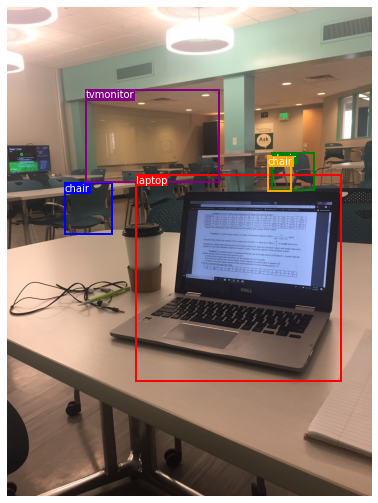

In [16]:
# Specify the id number of the image to display and the number of bounding boxes to display
imnum = 1
num_boxes = 5

# Load image
im_root = "/path/to/imagedir"
imgfile = im_root + "/{}".format(sas_results['_path_'][imnum].split("/")[-1])
im = Image.open(imgfile)

# Plot bounding boxes on image
plot_sas_topn(imnum, num_boxes, sas_results, im)

Much of post-processing is done through trial and error and inferring what the output means based on model information, but using output flattening and labelling makes the process much simpler. 